In [1]:
import gpflow as gp
import tensorflow as tf
import tensorflow_probability as tfp
from bayes_tec.datapack import DataPack
import numpy as np
from bayes_tec.utils.data_utils import calculate_weights, make_coord_array



def fit_joint_kern(datapack, num_samples=100, burn=50, kern=gp.kernels.RBF, ant_sel=None, time_sel=None,dir_sel=None, pol_sel=slice(0,1,1), freq_sel=None,tec_scale=0.01,
                  flag_dirs=[]):
    with DataPack(datapack,readonly=True) as datapack:
        datapack.select(time=time_sel, ant=ant_sel,pol=pol_sel, dir=dir_sel,freq=freq_sel)
        phase, axes = datapack.phase
        amp, axes = datapack.amplitude
        patch_names, directions = datapack.get_sources(axes['dir'])
        antenna_labels, antennas = datapack.get_antennas(axes['ant'])
        timestamps, times = datapack.get_times(axes['time'])
        _,freqs = datapack.get_freqs(axes['freq'])
        select = np.where(~np.isin(np.arange(len(patch_names)), np.array(flag_dirs)))
        patch_names = patch_names[select]
        directions = directions[select]

    gains = amp*np.exp(1j*phase)
    g_mu = gains.mean(-2)
    g_mu = g_mu[0,select,:,:]
    phi = np.unwrap(np.angle(g_mu),axis=-1)
    tec_conv = -8.448e9/freqs
    dtec = phi[0,...]/np.mean(tec_conv)
    var = calculate_weights(dtec,indep_axis=-1, N=50)
    var = np.median(np.median(var,axis=0))

        
    X_t = (times.mjd*86000. - times[0].mjd*86400.)
    X_t = X_t[:,None]
    X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), 
                  directions.dec.deg - directions.dec.deg.mean()]).T.astype(np.float64)
    X = make_coord_array(X_t, X_d,flat=True)
    
    Nd,Na,Nt = dtec.shape
    Y = dtec.transpose((2,0,1)).reshape((Nt*Nd,-1))/tec_scale
    
    with tf.Session(graph=tf.Graph()) as sess:
        with gp.defer_build():
            kernt = kern(1,active_dims=slice(0,1,1))
            kernd = kern(2,active_dims=slice(1,3,1))
            kernt.lengthscales = 230.
            kernt.lengthscales.transform = gp.transforms.positiveRescale(230.)
            kernd.lengthscales = 1.
            kernt.variance = 0.75
            kernt.variance.transform = gp.transforms.positiveRescale(0.75)
            kernd.variance.trainable = False
            kern = kernt*kernd
            m = gp.models.GPR(X,Y,kern)
            m.likelihood.variance = var/tec_scale**2#0.003**2/tec_scale**2
            m.likelihood.variance.trainable = False
            m.compile()
            gp.train.ScipyOptimizer().minimize(m)
            print(m)

#             with tf.variable_scope('custom'):
#                 global_step = tf.Variable(0, trainable=False)
#                 starter_learning_rate = 1e-2
#                 end_learning_rate = 1e-5
#                 decay_steps = 1e4
#                 learning_rate = tf.train.polynomial_decay(starter_learning_rate,
#                                                     global_step, decay_steps,
#                                                     end_learning_rate, power=1.)

#                 opt = tfp.optimizer.StochasticGradientLangevinDynamics(learning_rate).minimize(m.objective,
#                                                                                                var_list=m.trainable_tensors)
#             init = tf.variables_initializer(tf.global_variables('custom'))
            out_t = [u.constrained_tensor for u in m.parameters]
#             sess.run(init)
#             p = []
#             for i in range(num_samples):
#                 params, _ = sess.run([out_t, opt])
#                 p.append(params)
            p = sess.run(out_t)
    p = np.array(p)[[0,2,1,3]]
    p[2] = np.sqrt(p[2])*tec_scale
    p[3] = np.sqrt(p[3])*tec_scale
    
    return p



/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __n

In [3]:
import seaborn as sns
import pylab as plt
import pandas as pd
from bayes_tec.utils.data_utils import define_equal_subsets
import os

max_block_size, min_overlap = 100, 20
output_folder = './joint_kernel_solve_rbf'
os.makedirs(output_folder,exist_ok=True)

with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=True) as datapack:
    datapack.select(time=None, ant=None)
    axes = datapack.axes_phase
    patch_names, directions = datapack.get_sources(axes['dir'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    timestamps, times = datapack.get_times(axes['time'])
    _,freqs = datapack.get_freqs(axes['freq'])
    
Nt = len(times)
solve_slices, _, _ = define_equal_subsets(Nt,max_block_size, min_overlap)
    
time_ = []
hpd_5 = np.zeros((62,4,len(solve_slices)))
hpd_50 = np.zeros((62,4,len(solve_slices)))
hpd_95 = np.zeros((62,4,len(solve_slices)))
time_array = np.zeros((len(solve_slices),))

if os.path.isfile(os.path.join(output_folder,'results.npz')):
    d = np.load(os.path.join(output_folder,'results.npz'))
    hpd_5 = d['hpd_5']
    hpd_50 = d['hpd_50']
    hpd_95 = d['hpd_95']
    time_array = d['times']
    
    
for i in range(1,62,1):
    ant = antenna_labels[i]
    for j, solve_slice in enumerate(solve_slices):
        time_slice = slice(*solve_slice, 1)
        params = fit_joint_kern('../../scripts/data/killms_datapack_4.hdf5', 10, 
                                   burn=0,kern=gp.kernels.RBF, 
                                   ant_sel=slice(i,i+1,1), time_sel=time_slice,dir_sel=slice(0,45,1), 
                                   pol_sel=slice(0,1,1), freq_sel=slice(0,48,1),tec_scale=0.01,
                               flag_dirs=[3,9,10,11,12,16,17,27,31])

#         df = pd.DataFrame(params[:,:],columns=['ls_t','ls_d','sig','lik_sig'])
#         sns.kdeplot(df['ls_t'],df['ls_d'],shade=True)
#         plt.scatter(np.median(df['ls_t']),np.median(df['ls_d']),c='red')
        t = times[time_slice].mjd*86400.
        mean_time = int(np.mean(t))
        time_array[j] = mean_time
        time_.append(mean_time)
        hpd_5[i,:,j] = np.array([np.percentile(p,5) for p in params.T])
        hpd_50[i,:,j] = np.array([np.percentile(p,50) for p in params.T])
        hpd_95[i,:,j] = np.array([np.percentile(p,95) for p in params.T])
#         plt.title('Ant: {} | {}'.format(ant.astype(str),times[time_slice][t.size//2].isot))
#         plt.savefig(os.path.join(output_folder,'{}_{}_rbf.png'.format(ant.astype(str), mean_time)))
#         plt.close('all')
    np.savez(os.path.join(output_folder,'results.npz'),hpd_5=hpd_5, hpd_50 = hpd_50, hpd_95=hpd_95, times=time_array)

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and r

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -4533.356205
  Number of iterations: 20
  Number of functions evaluations: 116


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -4533.356205
  Number of iterations: 20
  Number of functions evaluations: 116
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


                                     class prior   transform  trainable shape  \
GPR/kern/kernels/0/lengthscales  Parameter  None  230.0* +ve       True    ()   
GPR/kern/kernels/0/variance      Parameter  None   0.75* +ve       True    ()   
GPR/kern/kernels/1/lengthscales  Parameter  None         +ve       True    ()   
GPR/kern/kernels/1/variance      Parameter  None         +ve      False    ()   
GPR/likelihood/variance          Parameter  None         +ve      False    ()   

                                 fixed_shape                 value  
GPR/kern/kernels/0/lengthscales         True    234.80930779735053  
GPR/kern/kernels/0/variance             True  0.009540008925062373  
GPR/kern/kernels/1/lengthscales         True    0.9514008033996957  
GPR/kern/kernels/1/variance             True                   1.0  
GPR/likelihood/variance                 True  0.009999999999999998  


/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/utils/data_utils.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  var = -np.log(Re2).astype(Y.dtype)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use f

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -4542.981223
  Number of iterations: 13
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -4542.981223
  Number of iterations: 13
  Number of functions evaluations: 95
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


                                     class prior   transform  trainable shape  \
GPR/kern/kernels/0/lengthscales  Parameter  None  230.0* +ve       True    ()   
GPR/kern/kernels/0/variance      Parameter  None   0.75* +ve       True    ()   
GPR/kern/kernels/1/lengthscales  Parameter  None         +ve       True    ()   
GPR/kern/kernels/1/variance      Parameter  None         +ve      False    ()   
GPR/likelihood/variance          Parameter  None         +ve      False    ()   

                                 fixed_shape                 value  
GPR/kern/kernels/0/lengthscales         True     307.1882307987129  
GPR/kern/kernels/0/variance             True   0.01611106732237122  
GPR/kern/kernels/1/lengthscales         True    1.1487087328357102  
GPR/kern/kernels/1/variance             True                   1.0  
GPR/likelihood/variance                 True  0.009999999999999998  


/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/utils/data_utils.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  var = -np.log(Re2).astype(Y.dtype)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use f

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4574.455786
  Number of iterations: 13
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4574.455786
  Number of iterations: 13
  Number of functions evaluations: 16
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


                                     class prior   transform  trainable shape  \
GPR/kern/kernels/0/lengthscales  Parameter  None  230.0* +ve       True    ()   
GPR/kern/kernels/0/variance      Parameter  None   0.75* +ve       True    ()   
GPR/kern/kernels/1/lengthscales  Parameter  None         +ve       True    ()   
GPR/kern/kernels/1/variance      Parameter  None         +ve      False    ()   
GPR/likelihood/variance          Parameter  None         +ve      False    ()   

                                 fixed_shape                 value  
GPR/kern/kernels/0/lengthscales         True     546.8393914691286  
GPR/kern/kernels/0/variance             True  0.020880958757098347  
GPR/kern/kernels/1/lengthscales         True    1.1793464578514352  
GPR/kern/kernels/1/variance             True                   1.0  
GPR/likelihood/variance                 True  0.009999999999999998  


/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/utils/data_utils.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  var = -np.log(Re2).astype(Y.dtype)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use f

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -4593.062134
  Number of iterations: 16
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -4593.062134
  Number of iterations: 16
  Number of functions evaluations: 57


                                     class prior   transform  trainable shape  \
GPR/kern/kernels/0/lengthscales  Parameter  None  230.0* +ve       True    ()   
GPR/kern/kernels/0/variance      Parameter  None   0.75* +ve       True    ()   
GPR/kern/kernels/1/lengthscales  Parameter  None         +ve       True    ()   
GPR/kern/kernels/1/variance      Parameter  None         +ve      False    ()   
GPR/likelihood/variance          Parameter  None         +ve      False    ()   

                                 fixed_shape                 value  
GPR/kern/kernels/0/lengthscales         True     627.4371417347006  
GPR/kern/kernels/0/variance             True  0.017828641836084166  
GPR/kern/kernels/1/lengthscales         True     1.115203178424918  
GPR/kern/kernels/1/variance             True                   1.0  
GPR/likelihood/variance                 True  0.009999999999999998  


/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/utils/data_utils.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  var = -np.log(Re2).astype(Y.dtype)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPfl

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -4528.093348
  Number of iterations: 16
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -4528.093348
  Number of iterations: 16
  Number of functions evaluations: 67
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


                                     class prior   transform  trainable shape  \
GPR/kern/kernels/0/lengthscales  Parameter  None  230.0* +ve       True    ()   
GPR/kern/kernels/0/variance      Parameter  None   0.75* +ve       True    ()   
GPR/kern/kernels/1/lengthscales  Parameter  None         +ve       True    ()   
GPR/kern/kernels/1/variance      Parameter  None         +ve      False    ()   
GPR/likelihood/variance          Parameter  None         +ve      False    ()   

                                 fixed_shape                 value  
GPR/kern/kernels/0/lengthscales         True      293.956674180026  
GPR/kern/kernels/0/variance             True  0.015060476389380377  
GPR/kern/kernels/1/lengthscales         True    0.8066175897011342  
GPR/kern/kernels/1/variance             True                   1.0  
GPR/likelihood/variance                 True  0.009999999999999998  


/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/utils/data_utils.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  var = -np.log(Re2).astype(Y.dtype)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use f

KeyboardInterrupt: 

In [68]:
flag_dirs=[3,9,10,11,12,16,17,27,31]
tec_scale=0.001
with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=True) as datapack:
    datapack.select(time=slice(0,50,1), ant='RS210HBA',pol=slice(0,1,1), dir=slice(0,45,1),freq=None)
    phase, axes = datapack.phase
    amp, axes = datapack.amplitude
    patch_names, directions = datapack.get_sources(axes['dir'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    timestamps, times = datapack.get_times(axes['time'])
    _,freqs = datapack.get_freqs(axes['freq'])
    select = np.where(~np.isin(np.arange(len(patch_names)), np.array(flag_dirs)))
    patch_names = patch_names[select]
    directions = directions[select]

gains = amp*np.exp(1j*phase)
g_mu = gains.mean(-2)
g_mu = g_mu[0,select,:,:]
phi = np.unwrap(np.angle(g_mu),axis=-1)
tec_conv = -8.448e9/freqs
dtec = phi[0,...]/np.mean(tec_conv)
var = calculate_weights(dtec,indep_axis=-1, N=50)
var = np.median(np.median(var,axis=0))


X_t = (times.mjd*86000. - times[0].mjd*86400.)
X_t = X_t[:,None]
X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), 
              directions.dec.deg - directions.dec.deg.mean()]).T.astype(np.float64)
X = make_coord_array(X_t, X_d,flat=True)

Nd,Na,Nt = dtec.shape
Y = dtec.transpose((2,0,1)).reshape((Nt*Nd,-1))/tec_scale


with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        kernt = gp.kernels.RBF(1,active_dims=slice(0,1,1))
        kernd = gp.kernels.RBF(2,active_dims=slice(1,3,1))
        kernt.lengthscales = 300.
        kernt.lengthscales.transform = gp.transforms.positiveRescale(230.)
        kernd.lengthscales = 3.
        kernd.lengthscales.trainable = True
        kernt.variance = 0.04
        kernt.variance.transform = gp.transforms.positiveRescale(0.75)
        kernd.variance.trainable = False
        kern = kernt*kernd
        kern.compile()
#     kern.lengthscales = np.array([100.,1.,1.])
    with tf.variable_scope('custom'):
        X_pl = tf.placeholder(tf.float64, shape=X.shape)
        #N, ndim=3
        X_ = tf.Variable(X_pl,trainable=False)
        Y_pl = tf.placeholder(tf.float64, shape=Y.shape)
        #N, L
        Y_ = tf.Variable(Y_pl,trainable=False)
        #N,N
        C_emp = tf.reduce_mean(Y_[:, :, None] * tf.transpose(Y_,(1,0))[None, :, :], axis=1)
        K = kern.K(X_)

        vars = kern.trainable_tensors
        L_emp = tf.cholesky(C_emp + 1e-3*tf.eye(tf.shape(X_)[0],dtype=tf.float64))
        L = tf.cholesky(K + 1e-3*tf.eye(tf.shape(X_)[0],dtype=tf.float64))

        loss = tf.reduce_sum(tf.square(L_emp - L))
        opt = tf.train.AdamOptimizer(1e-1).minimize(loss,var_list=vars)

    init = tf.variables_initializer(tf.global_variables('custom'))
    sess.run(init,feed_dict={X_pl:X, Y_pl: Y})
    for i in range(100):
        _, loss_, params = sess.run([opt, loss, [u.constrained_tensor for u in kern.parameters]])
        print(i, loss_,params)
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])
C_emp_ = L_emp_.dot(L_emp_.T)
K_ = L_.dot(L_.T)

    

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-bf753f5e-365/kernels/0/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-65-8d746ff32f16>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.eg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-bf753f5e-365/kernels/0/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-65-8d746ff32f16>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.eg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-bf753f5e-365/kernels/0/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-65-8d746ff32f16>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gp

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-bf753f5e-365/kernels/0/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-65-8d746ff32f16>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gp

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-bf753f5e-365/kernels/1/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-65-8d746ff32f16>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.eg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-bf753f5e-365/kernels/1/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-65-8d746ff32f16>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.eg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-bf753f5e-365/kernels/1/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-65-8d746ff32f16>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gp

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-bf753f5e-365/kernels/1/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-65-8d746ff32f16>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gp

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-ce9a1b01-373/kernels/0/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-66-06042526b8f1>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.eg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-ce9a1b01-373/kernels/0/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-66-06042526b8f1>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.eg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-ce9a1b01-373/kernels/0/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-66-06042526b8f1>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gp

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-ce9a1b01-373/kernels/0/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-66-06042526b8f1>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gp

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-ce9a1b01-373/kernels/1/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-66-06042526b8f1>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.eg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-ce9a1b01-373/kernels/1/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-66-06042526b8f1>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.eg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-ce9a1b01-373/kernels/1/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-66-06042526b8f1>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gp

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Product-ce9a1b01-373/kernels/1/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-66-06042526b8f1>", line 72, in <module>
    L_,L_emp_,B = sess.run([L,L_emp,C_emp])  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 59, in compile
    self.initialize(session, force=True)  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gp

0 282699.14744128496 [300.0, 0.039999999999999994, 3.0, 1.0]
1 282679.1338625543 [316.98283473237154, 0.03628410026572704, 3.0952508694594987, 1.0]
2 282658.34764958295 [334.4215613267292, 0.03298525167338463, 3.1909631375857073, 1.0]
3 282637.0062968178 [352.31415919338536, 0.030162761339047522, 3.287217859061096, 1.0]
4 282615.1632437974 [370.65664436678577, 0.027923858058743194, 3.3841191452713657, 1.0]
5 282592.50638910156 [389.4411019218019, 0.02641339287320607, 3.481761101334, 1.0]
6 282568.2910896306 [408.65687867365034, 0.02573782462220706, 3.580215979044751, 1.0]
7 282541.635001347 [428.2931833187852, 0.02587596764051254, 3.679537450007655, 1.0]
8 282511.8954796558 [448.34039876673813, 0.026707173839788705, 3.7797674677431172, 1.0]
9 282478.73669719975 [468.7896778644192, 0.028106033433995932, 3.8809396572046078, 1.0]
10 282442.01386004506 [489.63170058780344, 0.029988855636428877, 3.9830768887388035, 1.0]
11 282401.67372278444 [510.85548721290525, 0.03231445564002081, 4.08618

96 278180.62816158467 [2255.2914253170743, 2.5322569314957857, 6.236305087919657, 1.0]
97 278175.2190252473 [2267.4606318057185, 2.531676914852721, 6.232667217233744, 1.0]
98 278169.9660109128 [2279.465159648097, 2.5309742788865437, 6.229971073214248, 1.0]
99 278164.86077427154 [2291.3095533954497, 2.530183153179915, 6.228409610684823, 1.0]


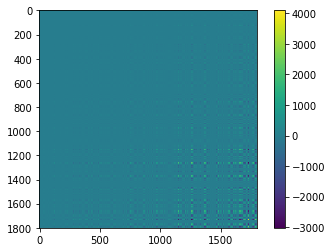

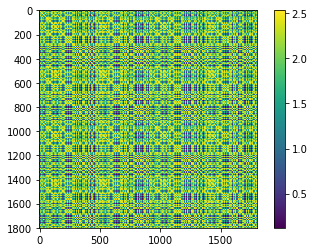

In [69]:
plt.imshow(C_emp_)
plt.colorbar()
plt.show()
plt.imshow(K_)
plt.colorbar()
plt.show()

In [150]:
flag_dirs=[3,9,10,11,12,16,17,27,31]
tec_scale=0.001

with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=True) as datapack:
    datapack.select(time=slice(0,100,1), ant='RS210HBA',pol=slice(0,1,1), dir=slice(0,45,1),freq=slice(0,48,1))
    phase, axes = datapack.phase
    amp, axes = datapack.amplitude
    patch_names, directions = datapack.get_sources(axes['dir'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    timestamps, times = datapack.get_times(axes['time'])
    _,freqs = datapack.get_freqs(axes['freq'])
    select = np.where(~np.isin(np.arange(len(patch_names)), np.array(flag_dirs)))[0]
#     patch_names = patch_names[select]
#     directions = directions[select]

gains = amp*np.exp(1j*phase)
gains = gains[:,select,:,:,:]
var = calculate_weights(gains.real,indep_axis=-1, N=4,phase_wrap=False) + calculate_weights(gains.imag,indep_axis=-1, N=4,phase_wrap=False)
var = var.mean(-2)
var[...,:2] = var[...,3:4]
var[...,-2:] = var[..., -3:-2]
var = np.median(np.median(var, axis=1))


X_t = (times.mjd*86000. - times[0].mjd*86400.)
X_t = X_t[:,None]
X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), 
              directions.dec.deg - directions.dec.deg.mean()]).T.astype(np.float64)
X = make_coord_array(X_t, X_d[select,:],flat=True)
Xstar = make_coord_array(X_t, X_d,flat=True)

_,Nd,Na,Nf,Nt = phase.shape
Nd_ = len(select)
#Nt*Nd, Na*Nf
Y = gains[0,...].transpose((3,0,1,2)).reshape((Nt*Nd_,-1))
Y = np.concatenate([Y.real,Y.imag],axis=1)
y_mean = Y.mean(0,keepdims=True)
Y -= y_mean
y_std = np.mean(Y.std(0,keepdims=True))+1e-8
Y /= y_std

var /= y_std**2


with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        kernt = gp.kernels.RBF(1,active_dims=slice(0,1,1))
        kernd = gp.kernels.RBF(2,active_dims=slice(1,3,1))
        kernt.lengthscales = 120.
        kernt.lengthscales.transform = gp.transforms.positiveRescale(120.)
        kernd.lengthscales = 1.
        kernd.lengthscales.trainable = True
        kernt.variance = 1.
#         kernt.variance.transform = gp.transforms.positiveRescale(1.)
        kernd.variance.trainable = False
        kern = kernt*kernd
        m = gp.models.GPR(X.astype(np.float64),Y.astype(np.float64),kern)
        m.likelihood.variance = var
        m.likelihood.variance.trainable = False
        m.compile()
    ystar,varstar = m.predict_y(Xstar.astype(np.float64))        
# #     kern.lengthscales = np.array([100.,1.,1.])
#     with tf.variable_scope('custom'):
#         X_pl = tf.placeholder(tf.float64, shape=X.shape)
#         #N, ndim=3
#         X_ = tf.Variable(X_pl,trainable=False)
#         Y_pl = tf.placeholder(tf.float64, shape=Y.shape)
#         #N, L
#         Y_ = tf.Variable(Y_pl,trainable=False)
#         #N,N
#         C_emp = tf.reduce_mean(Y_[:, :, None] * tf.transpose(Y_,(1,0))[None, :, :], axis=1)
#         K = kern.K(X_)

#         vars = kern.trainable_tensors
#         L_emp = tf.cholesky(C_emp + 1e-3*tf.eye(tf.shape(X_)[0],dtype=tf.float64))
#         L = tf.cholesky(K + 1e-3*tf.eye(tf.shape(X_)[0],dtype=tf.float64))

#         loss = tf.reduce_sum(tf.square(L_emp - L))
#         opt = tf.train.AdamOptimizer(1e-1).minimize(loss,var_list=vars)

#     init = tf.variables_initializer(tf.global_variables('custom'))
#     sess.run(init,feed_dict={X_pl:X, Y_pl: Y})
#     for i in range(100):
#         _, loss_, params = sess.run([opt, loss, [u.constrained_tensor for u in kern.parameters]])
#         print(i, loss_,params)
#     L_,L_emp_,B = sess.run([L,L_emp,C_emp])
# C_emp_ = L_emp_.dot(L_emp_.T)
# K_ = L_.dot(L_.T)

    

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecate

In [151]:
#Nt*Nd, Na*Nf
ystar = (ystar * y_std + y_mean)
real = ystar[:,:Na*Nf].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
imag = ystar[:,Na*Nf:].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
gstar = real + 1j*imag
varstar = varstar * y_std**2
real = varstar[:, :Na*Nf].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
imag = varstar[:, Na*Nf:].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
gvarstar = real + 1j*imag

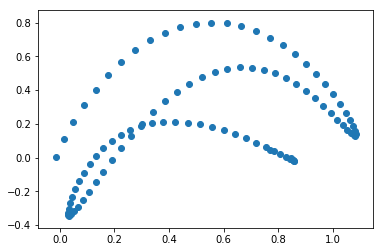

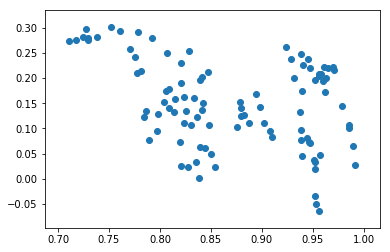

In [183]:
gains_ = amp*np.exp(1j*phase)

plt.scatter(gstar[9,0,0,:].real, gstar[9,0,0,:].imag)
plt.show()
plt.scatter(gains_[0,9,0,0,:].real, gains_[0,9,0,0,:].imag)
plt.show()

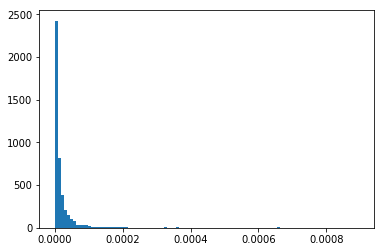

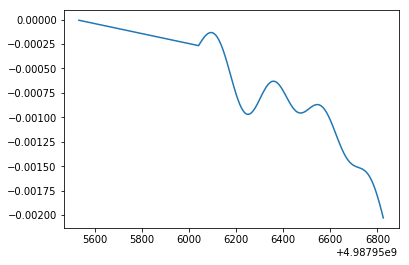

In [245]:
phi = np.angle(gstar)
tec_conv = -8.448e9/freqs
dtec = phi / tec_conv[:,None]
dtec_mu = (dtec*w_[:,None]).sum(-2)
dtec_u = (dtec**2*w_[:,None]).sum(-2) - dtec_mu**2

plt.hist(dtec_u.flatten(),bins=100)
plt.show()

plt.plot(times.mjd*86400,dtec_mu[0,0,:])
plt.show()

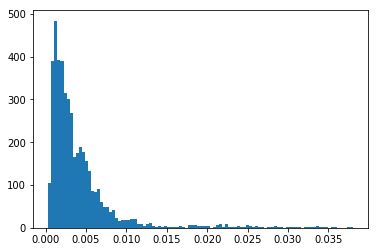

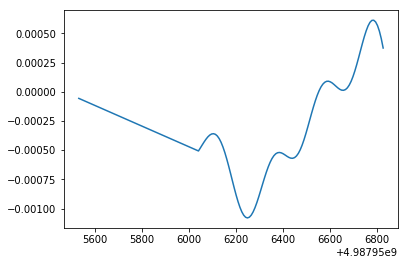

In [249]:
tec = np.mean(np.angle(gains_)/tec_conv[:,None],axis=-2)[0,...]

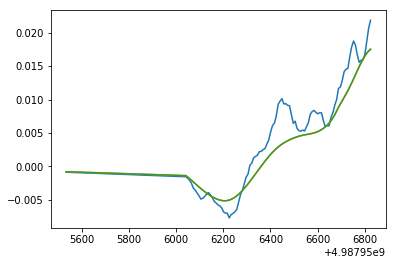

In [250]:
plt.plot(times.mjd*86400,tec[14,0,:])
plt.plot(times.mjd*86400,dtec_mu[14,0,:])
plt.plot(times.mjd*86400,(dtec_mu+dtec_u)[14,0,:])
plt.show()

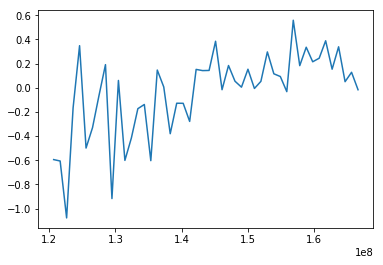

In [200]:
plt.plot(freqs,phi[0,0,:,99])
plt.show()

In [254]:


with tf.Session(graph=tf.Graph()) as sess:
    phi_pl = tf.placeholder(tf.float64)
    tec_conv_pl = tf.placeholder(tf.float64)
    log_w = tf.Variable(np.zeros(Nf),dtype=tf.float64)
    w = tf.exp(log_w)
    w /= tf.reduce_sum(w)
    
    dtec = phi_pl / tec_conv_pl[:,None]
    dtec_mu = tf.reduce_sum(dtec*w[:,None],axis=-2)
        
    dtec_var = tf.reduce_sum(dtec**2*w[:,None],axis=-2) - dtec_mu**2
    
    loss = tf.reduce_mean(dtec_var)# + tf.reduce_sum(tf.abs(w_))
    
    opt = tf.train.AdamOptimizer(1e-3).minimize(loss,var_list=[log_w])
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(1000):
        _, loss_, w_ = sess.run([opt, loss, w], feed_dict={phi_pl:np.angle(gains_), tec_conv_pl:tec_conv})
        print(i, loss_, w_)
    
    

0 8.020786895328914e-05 [0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333]
1 8.019604272424763e-05 [0.02081461 0.02081557 0.02081518 0.02081758 0.02081687 0.02081892
 0.02081996 0.0208222  0.02082642 0.02082353 0.02082139 0.02081992
 0.02082723 0.02082222 0.0208349  0.02083599 0.0208374  0.02083045
 0.02083971 0.02084413 0.02083792 0.0208448  0.02083573 0.02084014
 0.02083436 0.02084254 0.02084403 0.02084113 0.0208447  0.02084584
 0.020846   0.02084165 0.02084692 0.02084434 0.02084069 0.02084349
 0.0208429  0

26 7.979787596805084e-05 [0.02026383 0.02027417 0.02026986 0.02029816 0.0202893  0.02031596
 0.02033135 0.02036938 0.0204685  0.02039573 0.02035462 0.02033078
 0.02049608 0.02036994 0.02094913 0.02099978 0.02105144 0.02064171
 0.02111859 0.0212068  0.02106791 0.02121762 0.02099185 0.0211291
 0.02092876 0.02118016 0.02120572 0.02115204 0.02121629 0.02123293
 0.02123512 0.02116257 0.02124752 0.02121076 0.02114286 0.02119673
 0.02118639 0.02041228 0.02122315 0.0212121  0.02117421 0.0212107
 0.02034135 0.02112693 0.02092921 0.02117171 0.02039431 0.02030458]
27 7.978085809965675e-05 [0.02024121 0.02025178 0.02024737 0.02027631 0.02026725 0.02029452
 0.0203103  0.02034932 0.02045137 0.02037639 0.02033416 0.02030972
 0.02048    0.02034991 0.02095471 0.02100772 0.02106147 0.02063147
 0.02113115 0.02122215 0.02107855 0.02123332 0.02099962 0.02114202
 0.02093385 0.0211948  0.0212211  0.02116577 0.02123196 0.02124907
 0.0212513  0.02117662 0.02126404 0.02122628 0.02115633 0.02121184
 0.02120119 0

52 7.934484694351397e-05 [0.01967633 0.01969066 0.01968459 0.01972521 0.01971245 0.01975075
 0.01977402 0.01983156 0.01998926 0.01987186 0.0198085  0.01977327
 0.02004284 0.01983342 0.0210906  0.02121316 0.02132143 0.020324
 0.02145617 0.02161329 0.02135341 0.0216336  0.02120729 0.02147626
 0.02107444 0.02157189 0.02161448 0.02152142 0.02163179 0.02165923
 0.02166258 0.02153867 0.02168287 0.02162282 0.02150658 0.02159922
 0.02158102 0.01991251 0.02164345 0.02162453 0.02155904 0.0216225
 0.0197966  0.02147569 0.02106989 0.02155514 0.01988079 0.01973888]
53 7.932707161845973e-05 [0.01965384 0.01966826 0.01966215 0.0197031  0.01969023 0.01972883
 0.01975233 0.01981039 0.01996968 0.01985105 0.01978709 0.01975157
 0.0200242  0.01981232 0.02109557 0.02122141 0.02133199 0.0203098
 0.02146947 0.02162916 0.02136454 0.02164987 0.02121594 0.02148994
 0.02108043 0.02158735 0.02163052 0.02153603 0.02164806 0.02167588
 0.02167926 0.02155349 0.02169984 0.02163898 0.02152103 0.02161504
 0.02159653 0.0

79 7.885832348199943e-05 [0.01907417 0.01908983 0.01908305 0.01912962 0.01911503 0.01915812
 0.01918608 0.01925318 0.01943938 0.01929955 0.01922524 0.01918531
 0.01951726 0.01925743 0.02119885 0.02142879 0.02160386 0.01989644
 0.02181903 0.02204619 0.02165142 0.02207893 0.02144344 0.0218502
 0.02123988 0.02199724 0.0220544  0.02192356 0.02207739 0.02211469
 0.02211875 0.02194517 0.02214652 0.02206563 0.02190575 0.0220332
 0.02200681 0.01937704 0.02209402 0.02206693 0.02197392 0.02206481
 0.01922815 0.02185705 0.02122188 0.02196957 0.01933274 0.01915449]
80 7.884007121733614e-05 [0.0190521  0.01906776 0.01906097 0.01910767 0.01909304 0.0191362
 0.01916427 0.01923156 0.0194183  0.01927802 0.0192035  0.01916351
 0.01949704 0.01923592 0.02120159 0.02143635 0.02161412 0.019879
 0.02183256 0.02206238 0.02166226 0.02209565 0.02145221 0.02186418
 0.02124607 0.02201329 0.02207095 0.02193873 0.02209413 0.02213178
 0.02213587 0.02196045 0.02216391 0.02208228 0.02192086 0.02204954
 0.02202283 0.01

105 7.83793255789495e-05 [0.01850646 0.01852147 0.01851474 0.01856246 0.01854759 0.01859028
 0.01862044 0.01868929 0.01888005 0.01873569 0.01865931 0.01861971
 0.01897838 0.01869673 0.02122937 0.02161026 0.02186223 0.0194128
 0.02217116 0.02247012 0.02192479 0.0225185  0.02166834 0.02221516
 0.02139856 0.02242088 0.02249034 0.02232329 0.02251802 0.02256438
 0.02256875 0.0223468  0.02260375 0.02250411 0.02230552 0.02246353
 0.02242872 0.0188588  0.02253999 0.02250431 0.02238369 0.02250265
 0.01868729 0.02223642 0.02135987 0.02238002 0.01880332 0.01860165]
106 7.836073245700086e-05 [0.01848489 0.01849985 0.01849313 0.01854082 0.01852597 0.01856856
 0.01859877 0.01866757 0.01885815 0.01871387 0.01863755 0.01859804
 0.0189572  0.01867515 0.02122863 0.02161651 0.02187175 0.01939307
 0.02218468 0.02248654 0.02193489 0.02253561 0.02167681 0.02222924
 0.02140452 0.02243744 0.02250734 0.02233887 0.02253518 0.0225819
 0.02258627 0.02236242 0.02262155 0.02252121 0.02232117 0.02248031
 0.02244516 

131 7.789234901649529e-05 [0.01795274 0.01796566 0.01795953 0.01800497 0.01799091 0.0180295
 0.01806019 0.01812525 0.01830456 0.0181676  0.0180953  0.01805942
 0.01842009 0.01813657 0.02115345 0.02175028 0.02209678 0.01887896
 0.02252118 0.02289986 0.02217463 0.02296825 0.02188178 0.02258096
 0.02154696 0.02285727 0.02293792 0.02273339 0.02296974 0.02302512
 0.02302945 0.02275667 0.02307208 0.02295414 0.02271889 0.02290542
 0.0228615  0.01834415 0.02299797 0.02295263 0.02280217 0.022952
 0.01815681 0.02262561 0.02148146 0.02280054 0.01827819 0.01806151]
132 7.7873480270393e-05 [0.01793174 0.01794455 0.01793846 0.01798376 0.01796974 0.01800811
 0.01803879 0.01810362 0.01828224 0.01814576 0.0180737  0.01803802
 0.01839836 0.0181151  0.02114796 0.02175463 0.0221052  0.01885767
 0.02253455 0.0229165  0.02218364 0.02298576 0.02188966 0.022595
 0.02155235 0.0228743  0.02295537 0.02274936 0.02298734 0.02304307
 0.0230474  0.02277259 0.02309033 0.02297169 0.02273506 0.02292265
 0.02287836 0.01

158 7.737965571986125e-05 [0.01739404 0.01740358 0.01739854 0.01743878 0.0174264  0.01745775
 0.01748765 0.01754429 0.01770002 0.01757947 0.01751616 0.01748667
 0.01782985 0.01756019 0.02092856 0.02183499 0.02230492 0.01828998
 0.02287883 0.02335208 0.02239927 0.02344664 0.02208329 0.02295896
 0.02168112 0.02332402 0.02341561 0.02316977 0.02345127 0.02351618
 0.02352017 0.02319055 0.02357142 0.02343442 0.02316259 0.02337701
 0.02332285 0.0178176  0.02348733 0.02343057 0.02324596 0.02343166
 0.01761949 0.0230398  0.02158411 0.02324814 0.0177414  0.01751604]
159 7.736054391254083e-05 [0.01737368 0.01738308 0.01737808 0.01741809 0.01740579 0.01743682
 0.01746666 0.01752292 0.01767761 0.01755779 0.01749489 0.01746567
 0.01780789 0.017539   0.02091705 0.0218367  0.02231179 0.0182677
 0.02289191 0.02336895 0.02240677 0.02346459 0.02209025 0.02297289
 0.02168557 0.02334158 0.02343356 0.02318614 0.02346936 0.02353463
 0.0235386  0.02320678 0.02359018 0.02345247 0.02317932 0.02339474
 0.0233401

185 7.686078769435319e-05 [0.01685303 0.01685826 0.01685465 0.01688743 0.01687737 0.01689917
 0.01692726 0.01697199 0.01709638 0.016998   0.0169472  0.01692582
 0.01723693 0.01699287 0.02053697 0.02183865 0.02246559 0.01768117
 0.02322705 0.02381048 0.02257746 0.02393753 0.02225589 0.02333257
 0.02178517 0.02380524 0.02390745 0.02361695 0.0239466  0.02402137
 0.02402472 0.02363294 0.02408555 0.02392903 0.0236218  0.02386251
 0.02379733 0.017302   0.02399223 0.02392238 0.02369971 0.02392593
 0.01709776 0.02346465 0.0216574  0.02370777 0.01721619 0.01698764]
186 7.684146052110899e-05 [0.01683335 0.0168384  0.01683484 0.01686731 0.01685734 0.01687876
 0.01690676 0.016951   0.01707412 0.01697664 0.01692636 0.0169053
 0.017215   0.01697207 0.02051934 0.02183695 0.02247047 0.0176584
 0.02323972 0.02382758 0.022583   0.02395596 0.0222616  0.02334629
 0.0217883  0.02382335 0.02392595 0.02363372 0.02396522 0.02404036
 0.02404369 0.02364949 0.0241049  0.02394764 0.02363912 0.02388077
 0.02381517

212 7.633636081395998e-05 [0.01633023 0.0163304  0.01632849 0.01635205 0.01634474 0.01635531
 0.01638082 0.01641104 0.01649944 0.01642669 0.01639085 0.0163786
 0.01664734 0.01643716 0.01999313 0.02173993 0.02256553 0.01706442
 0.02356179 0.02427499 0.02269628 0.02444173 0.02238982 0.02369886
 0.02184759 0.02430146 0.02441437 0.02407495 0.02445673 0.02454181
 0.02454431 0.02408387 0.0246159  0.02443908 0.02409741 0.02436279
 0.02428592 0.01679921 0.02451409 0.0244293  0.02416403 0.0244361
 0.01659257 0.02390076 0.02169628 0.02418041 0.01670442 0.01647697]
213 7.631683688107501e-05 [0.01631122 0.01631119 0.01630935 0.01633253 0.01632533 0.01633546
 0.01636086 0.0163905  0.01647752 0.01640576 0.01637051 0.01635861
 0.01662563 0.01641683 0.01997056 0.02173403 0.02256787 0.01704155
 0.02357387 0.0242923  0.02269935 0.02446067 0.0223939  0.02371224
 0.02184893 0.02432014 0.02443345 0.02409212 0.02447592 0.0245614
 0.02456386 0.02410073 0.02463587 0.02445828 0.02411535 0.02438162
 0.0243043  

238 7.582650610509617e-05 [0.01584406 0.01583884 0.01583876 0.01585213 0.01584774 0.01584635
 0.01586886 0.0158833  0.01593486 0.01588842 0.01586855 0.01586558
 0.01608693 0.01591462 0.01936467 0.02152907 0.02259031 0.01647132
 0.02386685 0.02472769 0.02274081 0.02494039 0.02247161 0.02404131
 0.02185574 0.02479381 0.02491748 0.02452604 0.02496273 0.02505828
 0.02505978 0.02452601 0.02514308 0.02494572 0.02457169 0.02485921
 0.02477055 0.01632822 0.02503386 0.02493275 0.02462163 0.0249435
 0.0161221  0.02433193 0.02169664 0.0246487  0.01622537 0.01600214]
239 7.580680529752537e-05 [0.0158257  0.01582027 0.01582025 0.01583321 0.01582894 0.01582708
 0.01584946 0.01586327 0.01591339 0.01586797 0.01584874 0.01584613
 0.01606557 0.01589478 0.01933905 0.02151849 0.02258967 0.01644861
 0.02387817 0.0247452  0.02274096 0.02495983 0.02247367 0.02405424
 0.02185486 0.02481303 0.02493713 0.02454359 0.02498249 0.02507846
 0.02507991 0.02454317 0.0251637  0.02496553 0.02459026 0.0248786
 0.02478948

266 7.527240661259325e-05 [0.01533941 0.01532796 0.01532998 0.0153313  0.01533024 0.01531514
 0.01533399 0.0153301  0.01534131 0.0153237  0.01532209 0.01532921
 0.01549507 0.01536702 0.01862184 0.02116118 0.02252219 0.01584035
 0.02417067 0.02522069 0.02269564 0.02549253 0.02249446 0.02439465
 0.02179169 0.02534035 0.02547654 0.02502272 0.02552475 0.02563234
 0.02563261 0.02501072 0.02573028 0.02550945 0.02510137 0.02541081
 0.025309   0.01583623 0.02561401 0.02549304 0.02512667 0.02550904
 0.01563322 0.02480939 0.02165168 0.0251686  0.01572539 0.01550939]
267 7.525252312431229e-05 [0.01532175 0.01531007 0.01531217 0.01531304 0.01531211 0.0152965
 0.01531521 0.01531065 0.01532042 0.01530384 0.01530289 0.01531037
 0.01547419 0.01534777 0.01859459 0.0211453  0.02251773 0.01581804
 0.02418097 0.0252384  0.02269202 0.02551255 0.02249383 0.02440692
 0.02178779 0.02536019 0.02549685 0.02504066 0.02554517 0.0256532
 0.02565342 0.02502819 0.02575165 0.02552995 0.02512067 0.02543084
 0.02532856

292 7.475333216155841e-05 [0.01488828 0.01487078 0.01487482 0.01486421 0.01486632 0.01483801
 0.0148532  0.01483151 0.01480577 0.01481456 0.01483043 0.01484673
 0.01495885 0.01487356 0.01790639 0.0206898  0.02235665 0.01526635
 0.0244239  0.02568313 0.02255249 0.02602002 0.02244158 0.02470405
 0.02164923 0.02586349 0.02601259 0.02549391 0.0260635  0.02618314
 0.02618216 0.02546867 0.02629509 0.02605096 0.02561195 0.02593975
 0.02582548 0.01539407 0.02617322 0.02603153 0.02560793 0.02605343
 0.01519585 0.0252659  0.02156414 0.02566712 0.01527647 0.01506905]
293 7.473328003976891e-05 [0.01487126 0.01485353 0.01485765 0.01484656 0.0148488  0.01481998
 0.01483502 0.01481263 0.0147855  0.01479528 0.01481183 0.01482848
 0.01493851 0.01485488 0.01787873 0.02066935 0.02234816 0.01524455
 0.02443299 0.025701   0.02254486 0.0260406  0.02243793 0.02471552
 0.02164195 0.02588392 0.02603354 0.02551222 0.02608456 0.02620468
 0.02620365 0.02548643 0.0263172  0.02607215 0.02563196 0.02596043
 0.025845

318 7.422983215397672e-05 [0.01445372 0.01443    0.01443611 0.01441305 0.01441834 0.01437662
 0.01438796 0.0143481  0.01428668 0.01432093 0.01435446 0.01437954
 0.01443725 0.01439512 0.01718925 0.02011034 0.02208195 0.01470695
 0.0246425  0.02614935 0.02230007 0.02656235 0.02230374 0.0249904
 0.02141295 0.02640199 0.02656565 0.0259744  0.02661927 0.02675205
 0.02674974 0.0259339  0.02688005 0.02661096 0.02614162 0.02648568
 0.02635886 0.01496626 0.02675363 0.02658891 0.02610191 0.02661777
 0.01477434 0.02573598 0.02142963 0.02618204 0.01484257 0.01464506]
319 7.420960748553018e-05 [0.01443733 0.01441337 0.01441955 0.01439602 0.01440142 0.01435919
 0.01437038 0.01432981 0.01426705 0.01430226 0.01433647 0.01436188
 0.0144175  0.01437702 0.01716185 0.02008625 0.02206912 0.01468575
 0.02465012 0.02616734 0.02228807 0.02658351 0.02229657 0.02500087
 0.02140184 0.026423   0.02658726 0.02599306 0.026641   0.0267743
 0.02677194 0.02595193 0.02690297 0.02663288 0.02616238 0.02650703
 0.02637972

344 7.370177197796784e-05 [0.0140352  0.01400518 0.01401334 0.01397751 0.01398592 0.01393078
 0.01393817 0.01388004 0.01378469 0.01384314 0.01389423 0.01392757
 0.01393123 0.01393179 0.01648418 0.0194507  0.0216936  0.014164
 0.0248185  0.02661803 0.02193214 0.02711961 0.02206859 0.0252476
 0.02107327 0.02695562 0.02713593 0.02646331 0.02719238 0.02733963
 0.02733595 0.02640557 0.02748611 0.02719019 0.02669105 0.02704902
 0.02690976 0.01455264 0.02735627 0.02716615 0.02660913 0.0272031
 0.01436823 0.02622014 0.02124614 0.02671423 0.01442357 0.01423691]
345 7.368136878276648e-05 [0.01401941 0.01398915 0.01399739 0.01396106 0.01396959 0.01391393
 0.01392117 0.01386234 0.01376572 0.01382508 0.01387684 0.01391048
 0.01391209 0.01391427 0.01645742 0.01942415 0.02167642 0.01414347
 0.02482429 0.02663607 0.02191568 0.02714133 0.02205747 0.02525681
 0.02105808 0.0269772  0.0271582  0.02648227 0.02721477 0.0273626
 0.02735887 0.02642382 0.02750985 0.02721285 0.02671258 0.02707103
 0.0269313  0.

370 7.31690078014215e-05 [0.01363184 0.0135955  0.01360569 0.01355688 0.01356834 0.0134999
 0.01350329 0.01342705 0.01329982 0.01338099 0.01344936 0.0134903
 0.01344107 0.01348324 0.01579897 0.01874154 0.02119577 0.01363839
 0.02494235 0.02708694 0.02145071 0.02769115 0.02172723 0.02546808
 0.02062841 0.02752341 0.02772289 0.02695895 0.02778238 0.02794579
 0.02794071 0.02688199 0.02811357 0.02778869 0.02726024 0.02762949
 0.02747814 0.0141526  0.02798152 0.02776357 0.02712949 0.02780984
 0.01397673 0.02671826 0.02101243 0.02726391 0.01401889 0.01384374]
371 7.314842174999341e-05 [0.01361662 0.01358003 0.01359029 0.01354099 0.01355256 0.01348361
 0.01348685 0.01340991 0.0132815  0.01336352 0.01343254 0.01347377
 0.01342253 0.01346628 0.01577307 0.01871366 0.02117459 0.01361852
 0.02494593 0.02710494 0.02143006 0.0277134  0.02171192 0.02547571
 0.02060928 0.0275455  0.02774578 0.02697812 0.02780539 0.02796946
 0.02796433 0.02690038 0.02813812 0.02781209 0.02728252 0.02765214
 0.02750034 

396 7.263149208725215e-05 [0.01324246 0.01319981 0.01321199 0.01315013 0.01316453 0.01308303
 0.01308242 0.01298841 0.01283154 0.01293384 0.01301902 0.01306688
 0.01296649 0.01304871 0.01513755 0.01800927 0.02060207 0.01313017
 0.02500306 0.02755278 0.0208675  0.02827541 0.02127742 0.02564274
 0.02008694 0.02810342 0.02832503 0.02745861 0.02838789 0.02856953
 0.02856306 0.02736046 0.02876185 0.02840568 0.02784835 0.02822592
 0.0280631  0.01376513 0.02862891 0.02838068 0.02766205 0.02843758
 0.01359866 0.02722933 0.02072821 0.02783052 0.01362755 0.01346433]
397 7.26107247712801e-05 [0.01322774 0.01318486 0.01319711 0.01313474 0.01314925 0.01306726
 0.0130665  0.01297181 0.01281385 0.01291693 0.01300275 0.01305086
 0.01294854 0.01303226 0.01511261 0.01798093 0.02057759 0.01311097
 0.02500397 0.02757058 0.02084328 0.0282981  0.02125802 0.0256484
 0.0200644  0.02812593 0.02834846 0.02747786 0.02841146 0.02859385
 0.02858732 0.02737886 0.02878718 0.02842976 0.02787132 0.02824916
 0.02808591

422 7.208937671233101e-05 [0.01286564 0.01281677 0.01283086 0.01275598 0.01277319 0.01267898
 0.01267442 0.01256313 0.01237897 0.01250075 0.01260215 0.01265619
 0.0125068  0.01262717 0.01450143 0.01727336 0.01993343 0.01263888
 0.02498865 0.0280112  0.02020248 0.02886989 0.02072612 0.02576111
 0.01946667 0.02869277 0.02893994 0.02795856 0.02900661 0.029209
 0.02920116 0.02783726 0.02942955 0.02903951 0.02845361 0.02883627
 0.02866288 0.01338893 0.02929712 0.02901613 0.02820504 0.02908505
 0.0132326  0.02775145 0.02039421 0.0284126  0.0132483  0.01309724]
423 7.206843893871535e-05 [0.01285137 0.01280227 0.01281643 0.01274105 0.01275837 0.01266368
 0.01265897 0.01254703 0.01236186 0.01248436 0.01258637 0.01264063
 0.01248941 0.0126112  0.01447747 0.01724518 0.01990654 0.01262031
 0.02498643 0.02802861 0.0201756  0.02889292 0.02070308 0.02576439
 0.01944155 0.02871558 0.0289638  0.02797773 0.02903063 0.02923387
 0.02922599 0.0278555  0.0294556  0.02906419 0.0284772  0.02885999
 0.02868621

450 7.150088809758369e-05 [0.01247224 0.0124168  0.01243288 0.01234412 0.01236419 0.0122568
 0.01224807 0.01211889 0.01190799 0.01204889 0.01216694 0.01222682
 0.01202749 0.0121865  0.01384482 0.01649152 0.01915705 0.01212791
 0.02487551 0.02849068 0.01942267 0.02951796 0.02003755 0.02581283
 0.01873655 0.02933385 0.02961288 0.02849215 0.02968432 0.02991239
 0.02990315 0.02834372 0.03016804 0.02973831 0.02912187 0.02950604
 0.0293226  0.01299483 0.03003777 0.02971873 0.02879867 0.02980225
 0.01285014 0.02832314 0.0199812  0.02905441 0.01285184 0.01271401]
451 7.147979018426059e-05 [0.01245841 0.01240274 0.01241889 0.01232963 0.01234981 0.01224195
 0.01223308 0.01210328 0.01189147 0.01203302 0.01215165 0.01221172
 0.01201066 0.012171   0.01382191 0.01646394 0.0191286  0.01210999
 0.02486944 0.02850745 0.01939397 0.02954121 0.02001146 0.02581306
 0.01870963 0.02935681 0.02963706 0.02851104 0.0297087  0.02993776
 0.02992847 0.0283616  0.03019476 0.02976354 0.02914601 0.02953016
 0.0293463

477 7.092957470102357e-05 [0.01210369 0.01204208 0.01205999 0.01195808 0.01198076 0.01186121
 0.01184858 0.011703   0.01146891 0.01162646 0.01175964 0.01182437
 0.01157992 0.01177359 0.01323905 0.01575713 0.01837889 0.01165219
 0.02465891 0.02893291 0.01863537 0.03014683 0.01930582 0.02577577
 0.0179969  0.02995398 0.03026856 0.02899647 0.03034543 0.0306021
 0.0305916  0.02881971 0.03089675 0.03042526 0.02977934 0.03016085
 0.02996934 0.01262426 0.03077019 0.03041169 0.02937679 0.03051104
 0.0124914  0.02888038 0.01953466 0.02968537 0.0124799  0.01235489]
478 7.090835435138072e-05 [0.01209023 0.0120284  0.01204637 0.01194398 0.01196675 0.01184676
 0.01183399 0.01168782 0.01145292 0.01161105 0.01174478 0.01180967
 0.01156361 0.01175851 0.01321712 0.01573037 0.01834981 0.01163489
 0.02464874 0.02894883 0.01860586 0.03017015 0.0192778  0.0257726
 0.01796913 0.02997693 0.03029292 0.02901488 0.03037001 0.03062783
 0.03061728 0.02883703 0.03092402 0.03045091 0.0298039  0.03018522
 0.02999346

504 7.035542418803606e-05 [0.0117447  0.01167712 0.01169677 0.01158203 0.01160716 0.01147607
 0.01145969 0.01129865 0.01104387 0.01121635 0.01136367 0.0114325
 0.01114614 0.01137177 0.01265939 0.01504714 0.01759279 0.0111926
 0.02432902 0.02934924 0.01783618 0.03077599 0.0185342  0.02564225
 0.01724349 0.03057183 0.03092731 0.02948528 0.03101058 0.03130021
 0.03128857 0.0292781  0.03163948 0.03112244 0.03044672 0.03082131
 0.03062364 0.01226193 0.03151828 0.03111751 0.02995759 0.03123455
 0.01214145 0.02944027 0.01904649 0.0303257  0.01211711 0.01200488]
505 7.03341180299742e-05 [0.01173158 0.01166379 0.01168349 0.01156829 0.0115935  0.011462
 0.01144548 0.01128389 0.01102839 0.01120139 0.01134921 0.01141819
 0.01113033 0.01135709 0.01263841 0.01502135 0.01756374 0.01117588
 0.02431458 0.02936409 0.01780659 0.03079925 0.01850517 0.02563533
 0.01721555 0.03059462 0.03095172 0.02950302 0.03103525 0.03132619
 0.03131451 0.02929467 0.03166723 0.03114842 0.0304716  0.03084585
 0.03064798 0.

530 6.980080932861467e-05 [0.01140741 0.0113343  0.01135552 0.01122882 0.01125614 0.01111459
 0.01109474 0.01091979 0.01064739 0.01083266 0.01099259 0.01106473
 0.01074115 0.01099491 0.01212512 0.01438916 0.01684268 0.01076489
 0.02390236 0.02972027 0.01707122 0.03137915 0.0177751  0.02541459
 0.01651971 0.03116108 0.03156157 0.02993647 0.03165211 0.03197811
 0.03196554 0.02969804 0.03236622 0.03180133 0.03109632 0.03146011
 0.03125854 0.0119202  0.03225173 0.03180756 0.030517   0.03194351
 0.01181205 0.02997923 0.01854363 0.03094921 0.01177573 0.01167574]
531 6.977945704507779e-05 [0.01139459 0.01132128 0.01134256 0.01121541 0.0112428  0.01110087
 0.01108089 0.01090542 0.01063239 0.01081812 0.01097852 0.01105077
 0.01072582 0.01098061 0.01210503 0.01436438 0.0168141  0.01074873
 0.02388385 0.02973388 0.01704205 0.03140226 0.01774583 0.02540382
 0.01649205 0.03118358 0.03158593 0.02995338 0.03167677 0.03200427
 0.03199166 0.02971371 0.03239438 0.03182757 0.03112141 0.03148471
 0.031283

555 6.926680959016803e-05 [0.0110905  0.01101229 0.01103495 0.01089715 0.01092643 0.01077546
 0.01075243 0.01056506 0.01027776 0.01047393 0.01064502 0.01071975
 0.01036335 0.01064172 0.01163285 0.01378146 0.01613672 0.01036718
 0.02339507 0.03004469 0.01634999 0.03195424 0.01704564 0.0250998
 0.01583473 0.03171934 0.03216893 0.03034797 0.03226762 0.03263341
 0.03262011 0.03007772 0.03307439 0.03245945 0.03172538 0.0320749
 0.03187169 0.0115979  0.03296782 0.03247928 0.03105304 0.03263528
 0.01150194 0.03049504 0.01803636 0.03155358 0.01145449 0.01136619]
556 6.924544704352167e-05 [0.01107797 0.01099956 0.01102228 0.01088404 0.0109134  0.01076207
 0.01073891 0.01055107 0.0102632  0.01045979 0.0106313  0.01070613
 0.01034847 0.01062778 0.01161359 0.01375766 0.01610889 0.01035155
 0.02337291 0.03005694 0.01632153 0.03197712 0.01701664 0.02508523
 0.01580765 0.03174146 0.03219314 0.03036392 0.03229218 0.03265967
 0.03264634 0.03009236 0.0331029  0.03248586 0.03175061 0.03209948
 0.03189625

580 6.873295442484636e-05 [0.01078065 0.01069757 0.01072158 0.01057313 0.01060424 0.01044448
 0.01041843 0.01021962 0.0099193  0.01012508 0.01030636 0.01038318
 0.00999686 0.01029746 0.01116097 0.01319858 0.01545135 0.00998259
 0.02280159 0.03033304 0.01564906 0.03252243 0.01632719 0.0246905
 0.01516654 0.03226668 0.03277164 0.03073351 0.03287981 0.03329061
 0.03327679 0.03042978 0.03379077 0.03312138 0.03235705 0.03268847
 0.03248591 0.01128162 0.03369353 0.03315795 0.03158555 0.03333596
 0.01119807 0.0310065  0.01751213 0.03216143 0.01113992 0.01106316]
581 6.871161506524324e-05 [0.0107684  0.01068514 0.0107092  0.01056032 0.01059151 0.01043141
 0.01040524 0.010206   0.00990519 0.01011133 0.010293   0.01036989
 0.00998243 0.01028387 0.01114251 0.01317578 0.01542441 0.00996747
 0.02277623 0.03034376 0.0156215  0.03254499 0.01629879 0.0246722
 0.01514022 0.03228831 0.03279562 0.03074834 0.03290421 0.03331692
 0.03330309 0.03044323 0.03381958 0.03314792 0.03238235 0.03271296
 0.03251048

607 6.815752115446215e-05 [0.01045378 0.01036572 0.01039109 0.01023167 0.01026461 0.01009611
 0.01006698 0.00985692 0.00954456 0.00975934 0.00995053 0.01002908
 0.00961366 0.00993563 0.01067346 0.01259681 0.01473805 0.00958176
 0.0220792  0.03059909 0.01491922 0.03312603 0.0155717  0.02414639
 0.01446811 0.03284244 0.03341496 0.03111611 0.03353507 0.03400093
 0.03398684 0.03077443 0.03457265 0.03383907 0.03304027 0.03334785
 0.03314882 0.01094667 0.03448709 0.03389755 0.03215482 0.03410169
 0.01087671 0.03155178 0.01693374 0.03282046 0.01080752 0.01074304]
608 6.81362447712107e-05 [0.01044182 0.01035359 0.01037901 0.01021919 0.0102522  0.01008338
 0.01005414 0.00984369 0.00953092 0.00974601 0.00993755 0.01001615
 0.00959971 0.00992243 0.01065584 0.01257507 0.0147122  0.0095672
 0.02205107 0.03060797 0.01489277 0.03314815 0.0155442  0.02412431
 0.01444275 0.03286342 0.03343861 0.03112954 0.03355919 0.03402722
 0.03401314 0.03078642 0.03460175 0.03386569 0.03306557 0.03337219
 0.03317334

633 6.760548610120526e-05 [0.01014653 0.01005396 0.01008055 0.00991112 0.00994569 0.00976949
 0.00973759 0.00951779 0.00919568 0.00941787 0.00961755 0.00969728
 0.00925693 0.009597   0.01022495 0.01204403 0.0140796  0.00920983
 0.0213223  0.03080602 0.01424544 0.03369516 0.01486932 0.02353114
 0.01382093 0.0333787  0.03402466 0.03144667 0.03415813 0.03468396
 0.03466996 0.03106681 0.03533268 0.03453149 0.0336973  0.03397779
 0.03378513 0.0106306  0.03525992 0.03461521 0.03269546 0.03484697
 0.01057384 0.03206769 0.01637081 0.03345631 0.01049453 0.01044165]
634 6.758430829620216e-05 [0.01013486 0.01004212 0.01006875 0.00989895 0.00993358 0.0097571
 0.0097251  0.00950495 0.0091825  0.00940494 0.00960493 0.0096847
 0.00924345 0.00958417 0.01020809 0.01202328 0.01405485 0.0091958
 0.02129226 0.03081296 0.01422011 0.03371678 0.01484284 0.02350586
 0.01379656 0.03339892 0.03404788 0.03145858 0.03418191 0.03471019
 0.0346962  0.03107722 0.03536204 0.03455813 0.03372253 0.03400189
 0.03380954 

659 6.70564858629705e-05 [0.00984658 0.00974979 0.00977749 0.00959865 0.00963471 0.00945154
 0.00941705 0.00918857 0.00885842 0.00908683 0.009294   0.0093745
 0.00891214 0.00926796 0.0097962  0.0115167  0.01344988 0.00885147
 0.02052495 0.03096011 0.01360117 0.03425024 0.01419451 0.02283945
 0.0132     0.03389406 0.03462245 0.0317354  0.03477134 0.03536461
 0.03535109 0.0313159  0.03609886 0.03522383 0.03435158 0.03460105
 0.03441789 0.01032089 0.03604037 0.03533722 0.03322691 0.03559916
 0.01027733 0.03257242 0.01580722 0.03409212 0.01018845 0.01014693]
660 6.703544443703055e-05 [0.00983519 0.00973824 0.00976599 0.00958679 0.00962291 0.00943948
 0.0094049  0.00917611 0.00884567 0.00907431 0.00928174 0.00936226
 0.00889911 0.00925549 0.00978009 0.01149691 0.01342624 0.00883796
 0.02049373 0.03096492 0.01357699 0.03427128 0.01416913 0.02281153
 0.01317665 0.03391342 0.03464518 0.03174561 0.0347947  0.03539072
 0.03537723 0.03132455 0.03612844 0.03525044 0.03437666 0.03462486
 0.03444213

684 6.653237869568347e-05 [0.00956502 0.00946444 0.00949314 0.0093058  0.00934318 0.00915398
 0.00911719 0.00888134 0.00854492 0.00877831 0.00899174 0.00907262
 0.00859177 0.00896061 0.0094019  0.01103288 0.01287154 0.00851949
 0.01973733 0.03105458 0.01300968 0.03476883 0.01357298 0.02211723
 0.0126282  0.03436716 0.03518403 0.03196932 0.03534988 0.03601565
 0.03600304 0.03151043 0.03684074 0.03588832 0.03497641 0.03519256
 0.03502164 0.01002913 0.0367973  0.03603475 0.03372774 0.0363283
 0.00999821 0.0330452  0.01526865 0.0347024  0.00990065 0.00986978]
685 6.651150395717241e-05 [0.0095539  0.00945318 0.00948191 0.00929425 0.00933168 0.00914224
 0.00910536 0.00886924 0.0085326  0.00876617 0.00897983 0.00906072
 0.00857918 0.0089485  0.00938649 0.01101399 0.01284896 0.00850646
 0.01970562 0.03105721 0.01298658 0.03478924 0.01354868 0.0220874
 0.01260584 0.03438559 0.03520619 0.03197772 0.03537277 0.03604161
 0.03602905 0.03151724 0.03687051 0.03591486 0.03500129 0.03521604
 0.03504568

710 6.599217287600591e-05 [0.00927934 0.00917511 0.00920475 0.00900918 0.00904781 0.00885301
 0.00881401 0.00857149 0.00822998 0.00846756 0.00868657 0.00876754
 0.00827008 0.00865038 0.00900983 0.01055304 0.01229792 0.0081871
 0.01891208 0.03109344 0.0124233  0.03529063 0.0129555  0.02132367
 0.01205982 0.03483315 0.03575239 0.03216284 0.03593833 0.03668813
 0.03667701 0.03166186 0.03761719 0.0365771  0.03562012 0.03579829
 0.03564345 0.00973206 0.03759069 0.03676294 0.03423656 0.03709219
 0.00971415 0.03352184 0.01471541 0.035335   0.00960811 0.00958804]
711 6.59715072657319e-05 [0.0092685  0.00916413 0.0091938  0.00899793 0.00903661 0.00884161
 0.00880253 0.00855977 0.00821809 0.00845581 0.00867502 0.00875599
 0.00825794 0.00863864 0.00899511 0.01053504 0.01227642 0.00817458
 0.0188804  0.03109368 0.01240132 0.03531032 0.01293234 0.02129251
 0.01203849 0.03485051 0.0357739  0.03216921 0.03596067 0.03671389
 0.03670284 0.03166659 0.03764715 0.03660354 0.03564474 0.03582138
 0.03566723

733 6.551916254832646e-05 [0.00903271 0.0089255  0.0089559  0.00875357 0.00879321 0.00859403
 0.00855323 0.00830561 0.00796071 0.00820122 0.00842443 0.00850523
 0.00799519 0.00838398 0.00867779 0.01014769 0.01181364 0.00790384
 0.01818729 0.0310749  0.01192852 0.03573601 0.01243376 0.02059928
 0.01157913 0.03522119 0.03624045 0.03228844 0.03644641 0.03727844
 0.03726917 0.03174941 0.03830803 0.03718382 0.03618313 0.03632519
 0.03618747 0.00947478 0.0382975  0.0374091  0.03467545 0.03777248
 0.00946822 0.03392913 0.01423411 0.03589221 0.00935516 0.00934437]
734 6.549871032651109e-05 [0.00902212 0.00891478 0.00894521 0.0087426  0.00878228 0.00858292
 0.00854205 0.00829422 0.0079492  0.00818982 0.0084132  0.00849399
 0.00798345 0.00837256 0.00866366 0.01013046 0.01179307 0.00789176
 0.01815601 0.03107294 0.01190751 0.03575501 0.01241159 0.02056749
 0.0115587  0.03523752 0.03626133 0.03229289 0.03646821 0.03730401
 0.03729482 0.03175219 0.03833815 0.03721014 0.03620745 0.03634789
 0.036210

756 6.50513292338746e-05 [0.00879185 0.00868189 0.00871298 0.00850438 0.00854494 0.00834189
 0.00829944 0.00804744 0.00770011 0.00794287 0.00816962 0.00825006
 0.00772932 0.00812512 0.00835917 0.00975968 0.01135052 0.00763055
 0.01747482 0.03100497 0.01145561 0.03616517 0.01193468 0.01986538
 0.01111884 0.03558482 0.03671358 0.03236847 0.03694182 0.03786407
 0.0378572  0.03179077 0.03900264 0.03778769 0.03673907 0.03684303
 0.0367252  0.00922278 0.03900887 0.03805699 0.03510306 0.03845703
 0.00922737 0.03432163 0.01376211 0.03644676 0.00910776 0.00910597]
757 6.503111434504328e-05 [0.00878151 0.00867144 0.00870256 0.00849369 0.00853429 0.00833108
 0.00828857 0.00803639 0.00768898 0.00793182 0.00815871 0.00823913
 0.00771797 0.00811404 0.00834562 0.0097432  0.01133085 0.00761889
 0.01744421 0.03100075 0.01143554 0.03618344 0.01191348 0.01983341
 0.01109928 0.03560005 0.03673379 0.03237087 0.03696306 0.03788942
 0.03788267 0.03179149 0.03903292 0.03781388 0.03676307 0.03686533
 0.0367484

781 6.45492868070184e-05 [0.00853667 0.00842398 0.00845575 0.00824086 0.00828233 0.00807564
 0.00803156 0.00777558 0.00742661 0.00767111 0.007901   0.00798084
 0.00745047 0.00785235 0.00802761 0.00935692 0.01087038 0.00734461
 0.01672051 0.03086937 0.01096563 0.03661229 0.01141731 0.01906796
 0.01064111 0.03595064 0.03720988 0.03240094 0.03746509 0.03849506
 0.03849151 0.03178074 0.03976217 0.0384406  0.03733437 0.03739513
 0.03730202 0.00895502 0.0397874  0.03876325 0.03555445 0.03920615
 0.00897144 0.03473013 0.01326117 0.03704626 0.00884523 0.00885291]
782 6.452935324205352e-05 [0.00852661 0.00841381 0.00844561 0.00823048 0.00827198 0.00806516
 0.00802102 0.00776489 0.00741588 0.00766043 0.00789043 0.00797025
 0.00743953 0.00784162 0.00801466 0.00934121 0.01085167 0.00733341
 0.01669084 0.03086264 0.01094654 0.03662975 0.01139715 0.01903621
 0.01062249 0.03596461 0.03722933 0.03240102 0.03748568 0.03852018
 0.03851678 0.03177911 0.03979265 0.03846664 0.03735797 0.03741698
 0.0373249

807 6.403489193413906e-05 [0.00827868 0.00816343 0.00819582 0.007975   0.0080173  0.00780742
 0.00776181 0.00750249 0.00715281 0.00739842 0.00763084 0.00770988
 0.00717154 0.00757817 0.00769855 0.00895827 0.01039584 0.00705931
 0.01596315 0.03066177 0.01048167 0.03705505 0.01090619 0.01824936
 0.01016854 0.03629677 0.03770518 0.03237166 0.03799165 0.03914512
 0.03914591 0.03170699 0.04055764 0.03911573 0.03794254 0.03795706
 0.03789305 0.00868351 0.04060326 0.03950031 0.03600862 0.03999134
 0.00871189 0.03513352 0.01275496 0.03766604 0.00857938 0.00859654]
808 6.401527180759504e-05 [0.00826891 0.00815356 0.00818598 0.00796495 0.00800728 0.00779729
 0.00775162 0.00749219 0.0071425  0.00738813 0.00762064 0.00769964
 0.00716103 0.00756782 0.0076862  0.00894334 0.01037808 0.00704858
 0.01593462 0.03065243 0.01046356 0.03707161 0.01088707 0.01821822
 0.01015085 0.03630936 0.0377238  0.03236922 0.03801154 0.03917
 0.03917097 0.03170284 0.04058835 0.03914162 0.0379657  0.03797842
 0.0379156  

833 6.35288556791507e-05 [0.00802831 0.00791077 0.00794372 0.00771755 0.00776059 0.00754809
 0.00750111 0.00723922 0.00688974 0.00713579 0.00737007 0.00744815
 0.00690374 0.00731367 0.007385   0.00857941 0.0099456  0.00678607
 0.01523676 0.03038646 0.01002278 0.03747436 0.01042155 0.01745016
 0.00971988 0.03660616 0.03817834 0.03227559 0.03849955 0.03978907
 0.03979519 0.03156656 0.04135959 0.03978706 0.03853865 0.03850634
 0.0384748  0.00841927 0.04142601 0.04024056 0.03644692 0.04078356
 0.00845921 0.03551368 0.01226494 0.03828218 0.00832098 0.00834723]
834 6.35095647637351e-05 [0.00801883 0.00790121 0.00793418 0.00770782 0.00775088 0.00753829
 0.00749127 0.00722929 0.00687983 0.00712589 0.00736022 0.00743827
 0.00689366 0.00730369 0.00737325 0.00856522 0.00992875 0.0067758
 0.01520947 0.03037454 0.01000562 0.03749001 0.01040343 0.0174199
 0.00970309 0.0366173  0.03819609 0.03227054 0.03851871 0.03981372
 0.03982007 0.0315598  0.04139058 0.0398128  0.03856133 0.03852721
 0.03849699 0

858 6.305048378022291e-05 [0.00779481 0.00767532 0.00770873 0.00747796 0.00752162 0.00730709
 0.00725897 0.00699525 0.00664673 0.00689266 0.00712813 0.00720517
 0.00665658 0.00706843 0.00709762 0.00823303 0.00953463 0.00653447
 0.01456926 0.03005894 0.00960418 0.03785484 0.00997953 0.0167057
 0.00931016 0.03686745 0.03861172 0.03211843 0.03896979 0.04040282
 0.04041513 0.03136723 0.04213778 0.04042929 0.03909968 0.03902258
 0.03902534 0.00817219 0.04222435 0.04095606 0.03685335 0.04155291
 0.00822283 0.0358561  0.0118098  0.0388715  0.00807965 0.00811424]
859 6.30315191913009e-05 [0.00778562 0.00766605 0.00769948 0.00746854 0.00751222 0.00729762
 0.00724945 0.00698568 0.00663721 0.00688313 0.00711863 0.00719562
 0.0066469  0.0070588  0.00708641 0.00821953 0.00951862 0.00652463
 0.0145432  0.03004458 0.00958789 0.03786959 0.00996232 0.01667647
 0.0092942  0.03687715 0.0386286  0.0321108  0.03898822 0.04042727
 0.04043984 0.03135793 0.04216907 0.04045492 0.03912186 0.03904299
 0.03904718

882 6.259898548497943e-05 [0.00757734 0.0074562  0.00748999 0.00725529 0.00729946 0.00708343
 0.00703432 0.00676942 0.00642244 0.00666781 0.00690393 0.00697987
 0.00642864 0.0068413  0.00683425 0.00791632 0.00915947 0.00630292
 0.01395762 0.02968835 0.00922228 0.03819871 0.00957635 0.01601662
 0.00893604 0.03708359 0.03900726 0.0319067  0.03940407 0.04098741
 0.04100673 0.03111591 0.04289237 0.0410432  0.03962638 0.03950732
 0.0395457  0.00794154 0.04299819 0.04164717 0.03722971 0.04229951
 0.00800205 0.03616247 0.01138812 0.03943476 0.00785461 0.00789684]
883 6.258033892079968e-05 [0.00756843 0.00744722 0.00748103 0.00724617 0.00729036 0.00707427
 0.00702513 0.00676019 0.00641329 0.00665862 0.00689475 0.00697065
 0.00641933 0.00683201 0.00682354 0.00790346 0.00914424 0.00629348
 0.01393276 0.02967175 0.00920678 0.03821257 0.00955998 0.01598848
 0.00892084 0.03709184 0.0390233  0.03189657 0.03942179 0.04101168
 0.04103131 0.03110416 0.04292399 0.04106873 0.03964807 0.03952729
 0.039567

907 6.213681082654577e-05 [0.00735778 0.00723514 0.00726927 0.00703094 0.00707557 0.00685839
 0.00680838 0.00654278 0.00619798 0.00644233 0.00667867 0.00675338
 0.0062007  0.00661324 0.00657245 0.0076022  0.00878796 0.00607184
 0.01335084 0.02924646 0.00884429 0.03853415 0.00917742 0.01532764
 0.00856548 0.03727124 0.03939735 0.03162228 0.03983815 0.04159201
 0.04161987 0.0307917  0.04368736 0.04168041 0.04016195 0.04000113
 0.04007929 0.00770817 0.04381288 0.04237238 0.03760753 0.04308677
 0.00777851 0.03645729 0.01096499 0.04001941 0.00762713 0.00767693]
908 6.211849659530717e-05 [0.00734915 0.00722644 0.00726059 0.00702213 0.00706678 0.00684955
 0.00679952 0.00653389 0.00618919 0.00643349 0.00666983 0.0067445
 0.00619178 0.0066043  0.00656224 0.00758996 0.00877349 0.00606281
 0.0133272  0.02922765 0.00882957 0.03854707 0.0091619  0.01530071
 0.00855105 0.03727793 0.03941248 0.03160955 0.03985512 0.04161611
 0.04164434 0.03077741 0.04371936 0.04170586 0.04018308 0.04002064
 0.0401004

932 6.168292351070267e-05 [0.00714528 0.00702134 0.00705577 0.00681427 0.00685928 0.00664134
 0.00659056 0.00632474 0.00598264 0.00622559 0.00646172 0.00653515
 0.00598219 0.00639374 0.00632292 0.00730344 0.00843518 0.00585076
 0.01277447 0.02875106 0.00848554 0.03884588 0.00879896 0.0146692
 0.00821358 0.03741925 0.0397644  0.03127293 0.0402531  0.04219265
 0.04223045 0.03040459 0.04449266 0.04231578 0.04068338 0.04048379
 0.0406043  0.00748184 0.04463725 0.04310397 0.03797103 0.04388501
 0.00756154 0.03672619 0.01055837 0.04060248 0.00740673 0.00746369]
933 6.166493933082956e-05 [0.00713693 0.00701294 0.00704738 0.00680576 0.00685079 0.00663282
 0.00658202 0.00631619 0.00597421 0.0062171  0.00645322 0.00652659
 0.00597364 0.00638514 0.00631318 0.0072918  0.00842145 0.00584212
 0.01275204 0.02873019 0.00847158 0.03885785 0.00878423 0.0146435
 0.00819988 0.03742433 0.03977859 0.03125762 0.04026929 0.0422166
 0.04225483 0.03038782 0.0445251  0.04234116 0.04070393 0.04050287
 0.04062512 

955 6.12725892520579e-05 [0.00695595 0.006831   0.00686564 0.00662161 0.00666691 0.00644859
 0.00639721 0.00613157 0.00579234 0.00603372 0.00626933 0.00634151
 0.00578925 0.00619921 0.00610372 0.00704153 0.00812637 0.0056559
 0.01227031 0.02825171 0.00817166 0.03911125 0.00846795 0.01409067
 0.00790553 0.03751917 0.04008112 0.03089507 0.04061747 0.04274213
 0.04279043 0.02999436 0.04524369 0.04289909 0.04114985 0.04091816
 0.04107973 0.00727981 0.04540501 0.04378353 0.03829298 0.04463022
 0.00736772 0.03694971 0.0101988  0.04113799 0.00721017 0.00727336]
956 6.125490434958997e-05 [0.00694785 0.00682286 0.00685751 0.00661337 0.00665869 0.00644036
 0.00638895 0.00612333 0.00578423 0.00602554 0.00626112 0.00633325
 0.00578103 0.00619091 0.00609441 0.00703042 0.00811327 0.00564761
 0.01224894 0.02822911 0.00815835 0.03912232 0.00845392 0.01406611
 0.00789246 0.03752271 0.04009443 0.03087743 0.04063292 0.04276596
 0.04281475 0.02997538 0.04527658 0.04292443 0.04116983 0.04093683
 0.04110023

980 6.0834306383030804e-05 [0.00675675 0.00663088 0.00666571 0.00641932 0.00646487 0.00624646
 0.00619452 0.00592947 0.00559373 0.00583312 0.00606783 0.00613863
 0.00558802 0.00599559 0.00587623 0.00677023 0.00780696 0.00545302
 0.01174963 0.02766616 0.00784713 0.03937582 0.00812587 0.01349119
 0.0075869  0.03758699 0.04040181 0.03042477 0.04099399 0.04333637
 0.04339771 0.02949206 0.04607216 0.04353218 0.04164153 0.04137989
 0.04158818 0.00706691 0.04625051 0.04453017 0.03862957 0.04545325
 0.00716327 0.03716556 0.00982349 0.04171961 0.0070032  0.00707277]
981 6.081694011751636e-05 [0.00674892 0.00662302 0.00665786 0.00641138 0.00645694 0.00623853
 0.00618657 0.00592155 0.00558596 0.00582526 0.00605993 0.00613068
 0.00558015 0.00598762 0.00586736 0.00675966 0.00779452 0.0054451
 0.01172938 0.02764189 0.0078345  0.03938587 0.00811255 0.01346784
 0.0075745  0.0375888  0.04041412 0.0304047  0.04100862 0.04336008
 0.04342198 0.0294708  0.04610558 0.04355749 0.04166084 0.04139814
 0.041608

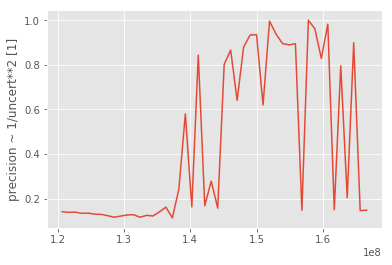

In [255]:
plt.style.use('ggplot')
plt.plot(freqs,w_/w_.max())
plt.ylabel('precision ~ 1/uncert**2 [1]')
plt.show()